Dataset loaded successfully.

--- CLASSIFICATION: WEEKDAY vs. WEEKEND CONSUMPTION ---
|   is_weekend |   Average_Consumption_kWh | Period   |
|-------------:|--------------------------:|:---------|
|            0 |                    1.0931 | Weekday  |
|            1 |                    1.3178 | Weekend  |


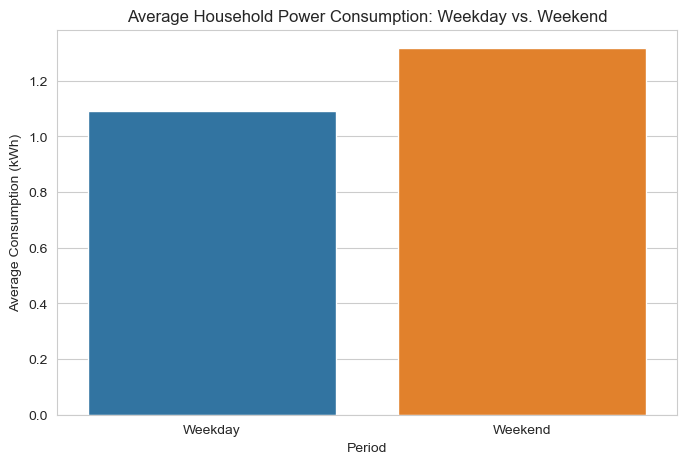


No missing values found.

Training set size: 1728 samples
Testing set size: 432 samples
Total features after encoding and scaling: 34

--- Training and Evaluating Models ---

Training Linear Regression...
Linear Regression complete. MAE: 0.0963, R2: 0.9003

Training Random Forest Regressor...
Random Forest Regressor complete. MAE: 0.0925, R2: 0.9101

Training Gradient Boosting Regressor...
Gradient Boosting Regressor complete. MAE: 0.0897, R2: 0.9143

             COMPARATIVE MODEL PERFORMANCE
|                             |    MAE |     R2 |
|:----------------------------|-------:|-------:|
| Gradient Boosting Regressor | 0.0897 | 0.9143 |
| Random Forest Regressor     | 0.0925 | 0.9101 |
| Linear Regression           | 0.0963 | 0.9003 |

--- Generating Visualizations for Gradient Boosting Regressor ---


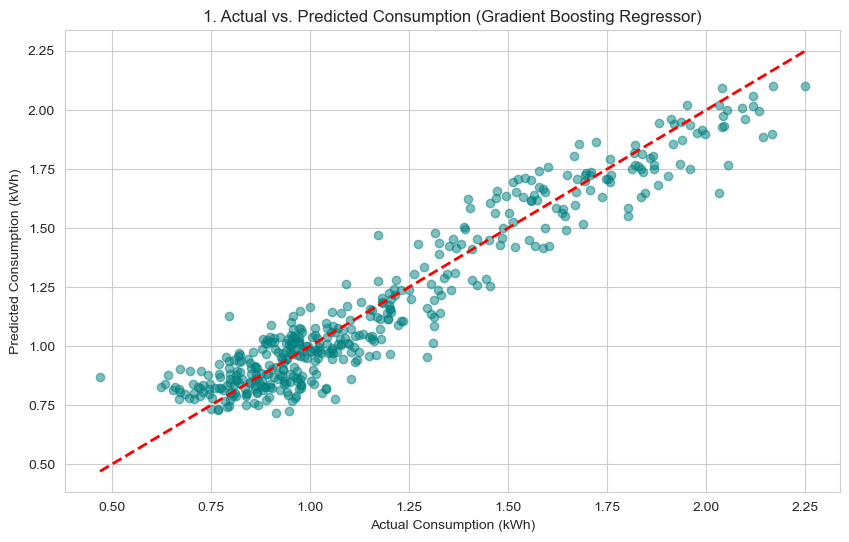

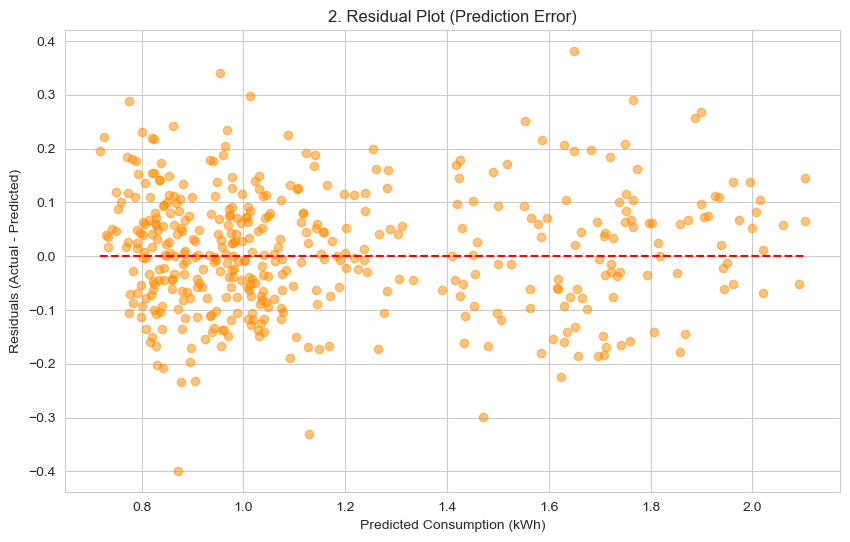


--- Feature Importance for Gradient Boosting Regressor ---

Top 5 Feature Importances (Higher is more impactful):
|                     |      0 |
|:--------------------|-------:|
| appliances_on_score | 0.4835 |
| outdoor_temp_c      | 0.4564 |
| is_weekend_1        | 0.0304 |
| is_holiday_1        | 0.0104 |
| humidity_pct        | 0.0103 |


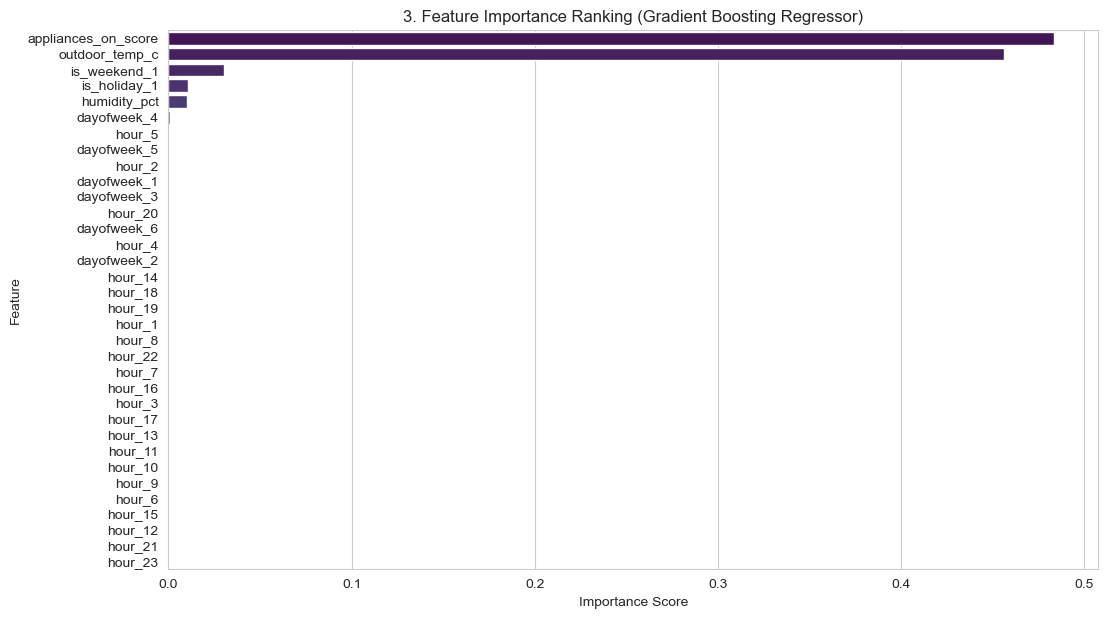

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plotting style
sns.set_style("whitegrid")

# Define categorical features that require one-hot encoding
CATEGORICAL_FEATURES = ['hour', 'dayofweek', 'is_weekend', 'is_holiday']
TARGET_COLUMN = 'consumption_kwh'

# 1. Load the dataset
try:
    df = pd.read_csv('Household_Power_Consumption_Prediction.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Household_Power_Consumption_Prediction.csv not found.")
    exit()

# --- NEW STEP: Classification Analysis (Average Consumption) ---
print("\n--- CLASSIFICATION: WEEKDAY vs. WEEKEND CONSUMPTION ---")

# Calculate average consumption grouped by the 'is_weekend' column
weekend_avg = df.groupby('is_weekend')[TARGET_COLUMN].mean().reset_index()
weekend_avg['Period'] = weekend_avg['is_weekend'].apply(lambda x: 'Weekend' if x == 1 else 'Weekday')
weekend_avg.rename(columns={TARGET_COLUMN: 'Average_Consumption_kWh'}, inplace=True)

print(weekend_avg.to_markdown(index=False, floatfmt=".4f"))

# Plot the average consumption
plt.figure(figsize=(8, 5))
sns.barplot(x='Period', y='Average_Consumption_kWh', data=weekend_avg, palette=['#1f77b4', '#ff7f0e'])
plt.title('Average Household Power Consumption: Weekday vs. Weekend')
plt.xlabel('Period')
plt.ylabel('Average Consumption (kWh)')
plt.show()
# --- END NEW STEP ---

# 2. Data Preprocessing and Feature Engineering

# Handle Missing Values (Imputation)
if df.isnull().values.any():
    print("\nWarning: Missing values detected. Filling with median.")
    for col in df.select_dtypes(include=np.number).columns:
        df[col].fillna(df[col].median(), inplace=True)
else:
    print("\nNo missing values found.")

# Drop the 'timestamp' column as its information is already extracted into 'hour' etc.
df_processed = df.drop('timestamp', axis=1)

# Apply One-Hot Encoding to categorical features
X_encoded = pd.get_dummies(df_processed.drop(TARGET_COLUMN, axis=1), 
                          columns=CATEGORICAL_FEATURES, 
                          drop_first=True)

y = df_processed[TARGET_COLUMN]

# Identify numerical features after encoding (these need scaling)
NUMERICAL_FEATURES = X_encoded.columns.difference(
    [col for col in X_encoded.columns if any(cat in col for cat in CATEGORICAL_FEATURES)]
).tolist()

# 3. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 4. Feature Scaling (Crucial for Linear Regression and overall optimization)
scaler = StandardScaler()
X_train[NUMERICAL_FEATURES] = scaler.fit_transform(X_train[NUMERICAL_FEATURES])
X_test[NUMERICAL_FEATURES] = scaler.transform(X_test[NUMERICAL_FEATURES])

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Total features after encoding and scaling: {X_train.shape[1]}")

# 5. Model Training and Evaluation

# Dictionary to hold the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=15,
        min_samples_split=5
    ),
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

results = {}

print("\n--- Training and Evaluating Models ---")

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "R2": r2, "y_pred": y_pred}
    
    print(f"{name} complete. MAE: {mae:.4f}, R2: {r2:.4f}")

# 6. Comparative Summary and Selection of Best Model
print("\n" + "="*50)
print("             COMPARATIVE MODEL PERFORMANCE")
print("="*50)

results_df = pd.DataFrame({k: v for k, v in results.items()}).T
results_df = results_df.drop('y_pred', axis=1)
results_df_sorted = results_df.sort_values(by="R2", ascending=False)

print(results_df_sorted.to_markdown(floatfmt=".4f"))
print("="*50)

# Determine the best model for visualization
best_model_name = results_df_sorted.index[0]
best_model = models[best_model_name]
best_y_pred = results[best_model_name]["y_pred"]

# 7. Model Visualization (using the Best Model)
print(f"\n--- Generating Visualizations for {best_model_name} ---")

# --- Plot 1: Actual vs. Predicted Consumption ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_y_pred, alpha=0.5, color='teal')
# Draw a perfect prediction line (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'1. Actual vs. Predicted Consumption ({best_model_name})')
plt.xlabel('Actual Consumption (kWh)')
plt.ylabel('Predicted Consumption (kWh)')
plt.show() 

# --- Plot 2: Residual Plot ---
residuals = y_test - best_y_pred
plt.figure(figsize=(10, 6))
# Plot residuals against predicted values
plt.scatter(best_y_pred, residuals, alpha=0.5, color='darkorange')
plt.hlines(0, best_y_pred.min(), best_y_pred.max(), colors='red', linestyles='--')
plt.title(f'2. Residual Plot (Prediction Error)')
plt.xlabel('Predicted Consumption (kWh)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show() 

# --- Plot 3: Feature Importance Bar Chart (if not Linear Regression) ---
if best_model_name != "Linear Regression":
    print(f"\n--- Feature Importance for {best_model_name} ---")
    
    # Use the column names from the processed training data
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    print("\nTop 5 Feature Importances (Higher is more impactful):")
    print(feature_importances_sorted.head().to_markdown(floatfmt=".4f"))

    plt.figure(figsize=(12, 7))
    sns.barplot(x=feature_importances_sorted, y=feature_importances_sorted.index, palette="viridis")
    plt.title(f'3. Feature Importance Ranking ({best_model_name})')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()